# Makemore: part 5 -- waveNet

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [13]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])


32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [14]:
# build the vocab of characters and amppings to/from integers
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i, s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s, i in s2i.items()}
vocab_size = len(i2s)
print(i2s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [15]:
# shuffle up the words
import random
random.seed(52)
random.shuffle(words)

In [16]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            idx = s2i[ch]
            X.append(context)
            Y.append(idx)
            #print(''.join(i2s[i] for i in context), '-->', i2s[idx])
            context = context[1:] + [idx] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xtst, Ytst = build_dataset(words[n2:]) # 10%

torch.Size([182498, 8]) torch.Size([182498])
torch.Size([22641, 8]) torch.Size([22641])
torch.Size([23007, 8]) torch.Size([23007])


In [17]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(i2s[ix.item()] for ix in x), '-->', i2s[y.item()])

........ --> b
.......b --> r
......br --> a
.....bra --> y
....bray --> l
...brayl --> i
..brayli --> n
.braylin --> .
........ --> n
.......n --> y
......ny --> o
.....nyo --> m
....nyom --> i
...nyomi --> .
........ --> t
.......t --> r
......tr --> e
.....tre --> n
....tren --> i
...treni --> y


In [27]:
# -----------------------------------------------------------------------------------------------------------------------------

from typing import Any


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in **0.5 # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------------------------------------
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# --------------------------------------------------------------------------------------------------------------------------------
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# to reduce the lines in the optimization part
# create two classes: embedding and flatten
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim)
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# ------------------------------------------------------------------------------------------------------------
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            # we don't want to return 3d tensor
            x = x.squeeze(1) # squeeze tensor with 1 demension
        self.out = x
        return self.out

    def parameters(self):
        return []

# ------------------------------------------------------------------------------------------------------------
class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [19]:
torch.manual_seed(42); # seed rng for reproducibility

In [36]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

#C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1

#parameters = [C] + [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of para in total
for p in parameters:
    p.requires_grad = True

76579


In [32]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

AttributeError: 'Embedding' object has no attribute 'out'

In [33]:
# same optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

    # forward pass
    # emb = C[Xb] # embed the characters into vectors
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    # further optimization
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None # initialization
    loss.backward()

    # update status
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0: # print every once in a while
        print(f'{i: 7d}/{max_steps:7d} : {loss.item(): .4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    

      0/ 200000 :  3.3003
  10000/ 200000 :  2.0341
  20000/ 200000 :  2.0811
  30000/ 200000 :  2.0264
  40000/ 200000 :  1.7103
  50000/ 200000 :  1.7906
  60000/ 200000 :  2.1746
  70000/ 200000 :  2.0246
  80000/ 200000 :  2.2478
  90000/ 200000 :  1.7258
 100000/ 200000 :  1.9682
 110000/ 200000 :  1.5558
 120000/ 200000 :  2.1506
 130000/ 200000 :  2.1284
 140000/ 200000 :  1.5814
 150000/ 200000 :  1.9981
 160000/ 200000 :  2.1496
 170000/ 200000 :  1.6392
 180000/ 200000 :  1.8976
 190000/ 200000 :  1.6916


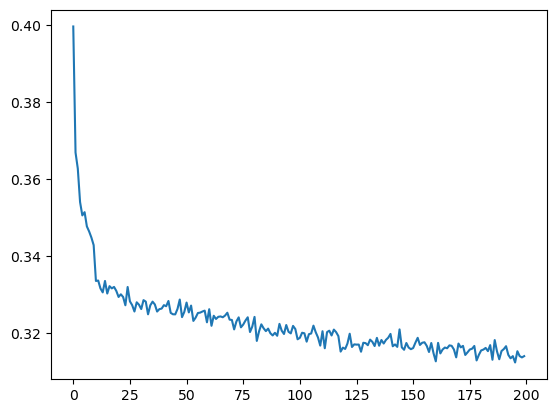

In [23]:
# plt.plot(lossi)
# fix the display
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))


In [34]:
# put layer into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [35]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': {Xtst, Ytst},
    }[split]
    logits = model(x)
    # emb = C[x] # (N, block_size, n_embd)
    # x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    # for layer in layers:
    #     x = layer(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8152726888656616
val 2.0131797790527344


# perfomance log
* original (3 char context + 200 hidden neurons, 12k params): train 2.058 val 2.105
* context 3 -> 8 (22k params): train 1.918 val 2.027
* flat -> hierachical : train 1.815 val 2.013 

In [26]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all...
    while True:
        # forward pass the neural net
        # emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        logits = model(torch.tensor([context]))
        # x = emb.view(emb.shape[0], -1) # concatenate the vectors
        # for layer in layers:
        #     x = layer(x)
        # logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distrubtion
        idx = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [idx]
        out.append(idx)
        # if we sample the special '.' token, break
        if idx == 0:
            break
    
    print(''.join(i2s[i] for i in out)) # decode and print the generated word

adeles.
lygwon.
livye.
coviescen.
leymande.
danox.
yuan.
kel.
ainae.
joreah.
evionte.
brakkemi.
joshu.
iva.
kiven.
gri.
zaedr.
auri.
rhiya.
jayuen.
